# Analysis of Yelp Business Intelligence Data

In this data analysis work, a subset of Yelp's business, reviews and user data is studied. These dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset).

## Installation and Initial Setup

Begin by installing the necessary libraries, pandas and matplotlib

In [108]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package already installed for current Spark context!
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/context.py", line 1110, in install_pypi_package
    raise ValueError("Package already installed for current Spark context!")
ValueError: Package already installed for current Spark context!



## Import
Now, import the installed packages from the previous block below.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as py

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

Spark is used to load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [4]:
from pyspark.sql import SparkSession
spark=SparkSession\
.builder \
.appName("YelpReviewsAnalysis") \
.getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
buiness_df=spark.read.json('s3://bucket2myh/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
The number of rows and columns in the dataset is displayed.

In [7]:
print(f'Total Columns: {len(buiness_df.dtypes)}')
print(f'Total Rows: {buiness_df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393

In [8]:
buiness_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str


Display the first 5 rows with the following columns:
- business_id
- name
- city
- state
- categories

In [11]:
buiness_df.createOrReplaceTempView('YelpBusiness')
B_sql_data1=spark.sql("SELECT business_id,name,city,state,categories FROM YelpBusiness").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Question answered: how many unique categories are represented in this dataset?
Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:
- How many businesses are categorized as Active Life, for instance
- What are the top 20 most popular categories available?

### Association Table
We need to "break out" these categories from the business_id's? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

This allows us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

In [85]:
B_sql_data2=spark.sql("SELECT business_id,categories FROM YelpBusiness")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

A Spark DF is derived associating business_id with categories. Each business_id is represented multiple times, 1 per category in this DF.

In [86]:
from pyspark.sql.functions import split, explode
data3 = B_sql_data2.select(B_sql_data2.business_id, explode(split(B_sql_data2.categories, ', ')).alias('category'))
data3.printSchema()
data3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- category: string (nullable = true)

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|         Active Life|
|f9NumwFMBDn751xgF...|    Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|         Guns & Ammo|
|f9NumwFMBDn751xgF...|            Shopping|
|Yzvjg0SayhoZgCljU...|    Health & Medical|
|Yzvjg0SayhoZgCljU...|Fitness & Instruc...|
|Yzvjg0SayhoZgCljU...|                Yoga|
|Yzvjg0SayhoZgCljU...|         Active Life|
|Yzvjg0SayhoZgCljU...|             Pilates|
|XNoUzKckATkOD1hP6...|                Pets|
|XNoUzKckATkOD1hP6...|        Pet Services|
|XNoUzKckATkOD1hP6...|        Pet Groomers|
|6OAZjbxqM5ol29BuH...|     Hardware Stores|
|6OAZjbxqM5ol29BuH...|       Home Services|
|6OAZjbxqM5ol29BuH...|   Building Supplies|
|6OAZjbxqM5ol29BuH...|       Home & Garden|
|6OAZjbxqM5ol29BuH...|            Shopping|
|51M2Kk903DFYI6gnB...|       Ho

In [113]:
data3.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

There are **1336** dictinct categories in this dataset.




A new Spark DF is derived from the previous DF that represents the number of businesses per category.

In [87]:
from pyspark.sql.functions import count
data3.groupBy("category").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|      Data Recovery|  195|
|      Videographers|  169|
|      Skating Rinks|  104|
|             Fondue|   54|
|    Pet Photography|   49|
|  Pet Waste Removal|   34|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|       Aerial Tours|   28|
|  Signature Cuisine|    1|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

## Bar Chart of Top Categories
With the above data available, let us now build a barchart of the top 20 categories.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

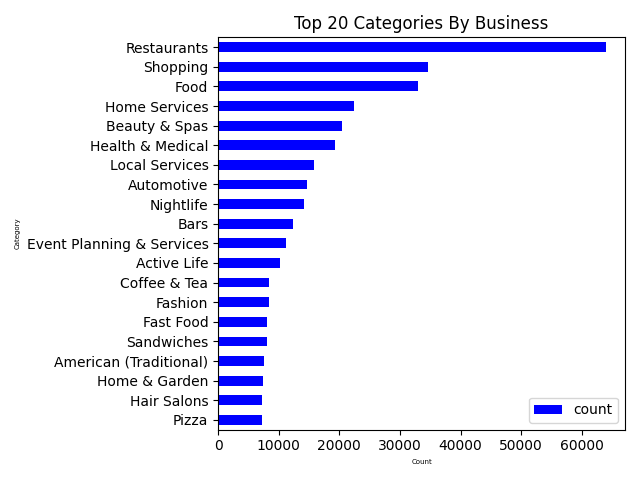

In [17]:
data4=data3.groupBy("category").count().sort('count',ascending=False).limit(20).toPandas()
ax = data4.plot(kind='barh', x='category', y='count',color='blue')
ax.set_xlabel("Count",size=5)
ax.set_ylabel("Category",size=5)
ax.set_title("Top 20 Categories By Business",size=12)
plt.tight_layout()
plt.gca().invert_yaxis()
%matplot plt

# Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.
How true is this really? Let's try and answer this question.

## Loading User Dataset
Loding data from S3.

In [88]:
review_df=spark.read.json('s3://bucket2myh/yelp_academic_dataset_review.json')
review_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Listing the business_id and stars columns together for the reviews data.

In [21]:
review_df.createOrReplaceTempView('YelpReview')
review_data=spark.sql("SELECT business_id,stars FROM YelpReview")
review_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who took the time to submit a written review.

In [22]:
Rdata=review_data.groupBy('business_id').avg()
Rdata.show(5)  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Join our two dataframes (reviews and business data) by **business_id**.

In [23]:
RB_Joined_data = Rdata.join(df, on=['business_id'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
Cdata=RB_Joined_data.select('avg(stars)','stars','name','city','state').sort('avg(stars)',ascending=False)
Cdata.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+
|avg(stars)|stars|                name|     city|state|
+----------+-----+--------------------+---------+-----+
|       5.0|  5.0|Carbonation Craft...|Cornelius|   NC|
|       5.0|  5.0|PartyZams Singing...|Las Vegas|   NV|
|       5.0|  5.0|Design Array Gara...|   Peoria|   AZ|
|       5.0|  5.0|Andre Agassi Coll...|Las Vegas|   NV|
|       5.0|  5.0|       The Elf Squad|Charlotte|   NC|
+----------+-----+--------------------+---------+-----+
only showing top 5 rows


Compute a new dataframe that calculates what we will call the **skew**  between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **(reviews dataset)** and reviewers who just provided a star rating **(business dataset)**).
The formula is:

(row['avg(stars)'] - row['stars']) / row['stars']

If the skew is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If skew is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [25]:
Cdata = Cdata.withColumn('skew', ( Cdata['avg(stars)'] - Cdata['stars'] ) / Cdata['stars'] )
Cdata.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+----+
|avg(stars)|stars|                name|     city|state|skew|
+----------+-----+--------------------+---------+-----+----+
|       5.0|  5.0|    Carpet Closeouts|  Phoenix|   AZ| 0.0|
|       5.0|  5.0|Allyson Juneau-Bu...|Henderson|   NV| 0.0|
|       5.0|  5.0| Leno Fine Jewellery|  Calgary|   AB| 0.0|
|       5.0|  5.0|         Burdick Law|Las Vegas|   NV| 0.0|
|       5.0|  5.0|The Shrine of the...|Las Vegas|   NV| 0.0|
+----------+-----+--------------------+---------+-----+----+
only showing top 5 rows

**Graph it!**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

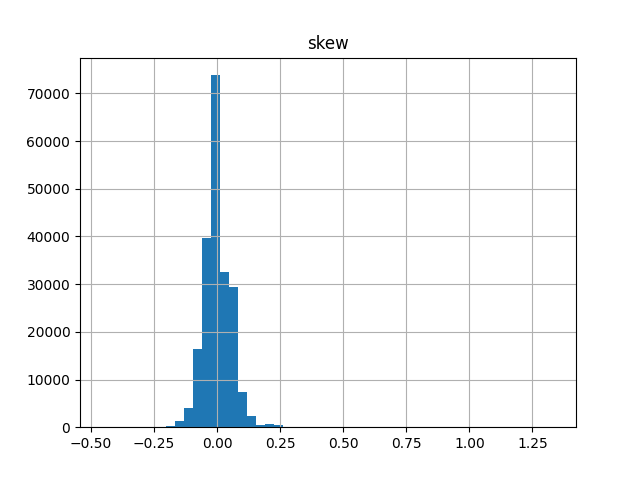

In [26]:
Cdata.toPandas().hist('skew', bins = 50)
%matplot plt

From the **skew** graph above, the Yelp (written) Reviews doesn't really skew negative. Most of these ratings of stars matches. Meaning there is no significant difference between the ratings of a business and what the average ratings of reviewers who spend time on actually writing a review.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

Question to be Answered: How accurate or close are the ratings of an "elite" user (from users dataset) vs the actual business rating.

In this part, the ratings of 'elite' users are found by matching its **"user_id"** with the **review** dataset.

### Data Loading for User dataset

In [27]:
user_df=spark.read.json('s3://bucket2myh/yelp_academic_dataset_user.json')
user_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Getting ratings for a specific user who has unique **user_id** on user dataset and reviews dataset.

In [94]:
review_df.createOrReplaceTempView('YelpReview')
R_sql_data=spark.sql("SELECT business_id,stars,user_id FROM YelpReview")
userID_df=user_df.select('user_id')
RU_data=R_sql_data.join(userID_df, on=['user_id'])
RU_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+
|             user_id|         business_id|stars|
+--------------------+--------------------+-----+
|-0Ji0nOyFe-4yo8BK...|pmrHuQiy25xKB86tb...|  4.0|
|-0XPr1ilUAfp-yIXZ...|QhwaGi1niDeVEHMRt...|  2.0|
|-1KKYzibGPyUX-Mwk...|L772e6l2Yd0DJEyCB...|  4.0|
|-1zQA2f_syMAdA04P...|DyYS-JKXlW2PCr_Gt...|  5.0|
|-1zQA2f_syMAdA04P...|aNe8ofTYrealxqv7V...|  5.0|
|-1zQA2f_syMAdA04P...|5c-b0ALS_DyLvRCGr...|  1.0|
|-1zQA2f_syMAdA04P...|sAS4fHDiK8A9a1wEA...|  1.0|
|-1zQA2f_syMAdA04P...|fuC3sui68QWg-rqld...|  1.0|
|-2G_a0eur5RTmI-vc...|Ueuo4VdUlDFoeHixY...|  1.0|
|-2G_a0eur5RTmI-vc...|dLc1d1zwd1Teu2QED...|  5.0|
|-2G_a0eur5RTmI-vc...|in39cUCMBRjpwxw7q...|  5.0|
|-2G_a0eur5RTmI-vc...|0PVxodALQu-soL5J8...|  5.0|
|-2G_a0eur5RTmI-vc...|bGdsMEAf6cijRl-tr...|  4.0|
|-2G_a0eur5RTmI-vc...|zMfZLd5_h5W8ZVxTN...|  3.0|
|-2Pb5d2WBPtbyGT_b...|HhVmDybpU7L50Kb5A...|  5.0|
|-2gEBUGicw7HtLX0K...|sR9hPrIaG-J-GLcl4...|  5.0|
|-2gEBUGicw7HtLX0K...|aGA_iSHm9laGTrfPL...|  5.0|


Given user-given rating "stars" a new name **"User_stars"**.

In [100]:
RU_data=RU_data.withColumnRenamed("stars","User_stars")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
B_sql_data2=spark.sql("SELECT business_id,stars FROM YelpBusiness")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
result_df=B_sql_data2.join(RU_data, on=['business_id'])
result_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+----------+
|         business_id|stars|             user_id|User_stars|
+--------------------+-----+--------------------+----------+
|pmrHuQiy25xKB86tb...|  4.0|-0Ji0nOyFe-4yo8BK...|       4.0|
|QhwaGi1niDeVEHMRt...|  2.5|-0XPr1ilUAfp-yIXZ...|       2.0|
|L772e6l2Yd0DJEyCB...|  3.0|-1KKYzibGPyUX-Mwk...|       4.0|
|aNe8ofTYrealxqv7V...|  3.5|-1zQA2f_syMAdA04P...|       5.0|
|5c-b0ALS_DyLvRCGr...|  2.5|-1zQA2f_syMAdA04P...|       1.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows

'Uesr_stars' are ratings from 'elite' users and 'star' are actual ratings of businesses.




### The **accuracy** is determined by the following formula:

( row['User_stars'] - row['stars'] )*100 /5 )

On a 5-point scale, given a acurracy of 0.1 meaning: users' rating toward a specific business is 10% off its actual rating.

In [104]:
res_df= result_df.withColumn('accuracy', ( result_df['User_stars'] - result_df['stars'] )/5 )
res_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+----------+--------+
|         business_id|stars|             user_id|User_stars|accuracy|
+--------------------+-----+--------------------+----------+--------+
|pmrHuQiy25xKB86tb...|  4.0|-0Ji0nOyFe-4yo8BK...|       4.0|     0.0|
|QhwaGi1niDeVEHMRt...|  2.5|-0XPr1ilUAfp-yIXZ...|       2.0|    -0.1|
|L772e6l2Yd0DJEyCB...|  3.0|-1KKYzibGPyUX-Mwk...|       4.0|     0.2|
|DyYS-JKXlW2PCr_Gt...|  3.5|-1zQA2f_syMAdA04P...|       5.0|     0.3|
|aNe8ofTYrealxqv7V...|  3.5|-1zQA2f_syMAdA04P...|       5.0|     0.3|
+--------------------+-----+--------------------+----------+--------+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

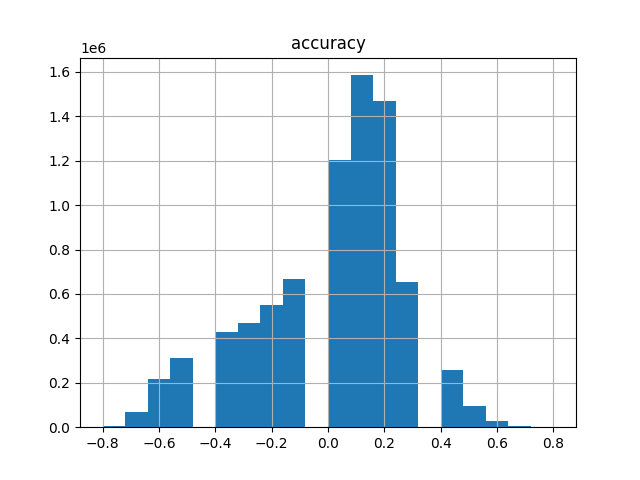

In [114]:
res_df.toPandas().hist('accuracy',bins=20)
%matplot plt

The graph above shows that most elite users gives accurate or a more positive ratings for businesses. However, there are cases that they gives extremely worse ratings.